In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns  
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Scikit-Learn modules for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('data/games.csv')

In [3]:
# Check the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB
None


In [4]:
# Dataset Shape and Data Types
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes.value_counts())

# Summary of numerical columns
df.describe()

# Count unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Shape: (20058, 16)

Data Types:
object     9
int64      4
float64    2
bool       1
Name: count, dtype: int64
id: 19113 unique values
victory_status: 4 unique values
winner: 3 unique values
increment_code: 400 unique values
white_id: 9438 unique values
black_id: 9331 unique values
moves: 18920 unique values
opening_eco: 365 unique values
opening_name: 1477 unique values


In [5]:
# What are the victory statuses?
victory_counts = df['victory_status'].value_counts()
print("\nVictory Status Counts:")
print(victory_counts)


Victory Status Counts:
victory_status
resign       11147
mate          6325
outoftime     1680
draw           906
Name: count, dtype: int64


In [6]:
# Check for missing values
print(df.isnull().sum())

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64


In [7]:
# Preview the dataset
print(df.head())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

In [8]:
# Drop columns that are not useful for modeling
df_processed = df.drop(columns=['id', 'rated', 'created_at', 'last_move_at', 'white_id', 'black_id', 'moves', 'opening_name', 'victory_status', 'turns'])

In [9]:
# Draws are not considered victories, so we can drop them
df_processed = df_processed[df_processed['winner'] != 'draw']

In [10]:
# The 'winner' column has 3 outcomes. Let's map them to numbers.
df_processed['winner'] = df['winner'].map({'white': 1, 'black': -1})

In [11]:
df_processed['rating_difference'] = df_processed['white_rating'] - df_processed['black_rating']

# Now that we have the difference, the individual ratings are less important.
# We can drop them to avoid multicollinearity.
df_processed = df_processed.drop(columns=['white_rating', 'black_rating'])

In [12]:
# Let's see the most common opening codes
print(df_processed['opening_eco'].value_counts().head(10))

opening_eco
A00    968
C00    806
D00    701
B01    690
C41    663
C20    654
A40    599
B00    583
B20    543
C50    508
Name: count, dtype: int64


In [13]:
# Group all openings that appear less than, say, 10 times into an 'Other' category
opening_counts = df_processed['opening_eco'].value_counts()
rare_openings = opening_counts[opening_counts < 10].index
df_processed['opening_eco'] = df_processed['opening_eco'].replace(rare_openings, 'Other')

print(f"\nNew number of unique opening ECOs: {df_processed['opening_eco'].nunique()}")


New number of unique opening ECOs: 184


In [14]:
# Create new columns for base time and increment. Handle cases with no increment.
time_split = df['increment_code'].str.split('+', expand=True)
df_processed['base_time_seconds'] = pd.to_numeric(time_split[0]) * 60
df_processed['increment_seconds'] = pd.to_numeric(time_split[1])

# Now you can drop the original increment_code column
df_processed = df_processed.drop(columns=['increment_code'])

In [15]:
# Create the features (X) and target (y)
X = df_processed.drop('winner', axis=1)
y = df_processed['winner']

# Convert categorical variables into dummy/indicator variables
X = pd.get_dummies(X, columns=['opening_eco'], drop_first=True)

In [16]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (15286, 187)
Testing set shape: (3822, 187)


In [17]:
# Baseline: Predict winner based only on rating difference
# 1 if white has higher rating, -1 if black has higher rating
baseline_preds = np.sign(X_test['rating_difference'])

# Note: This simple baseline can't predict draws (0), so we'll replace 0s with 1 (predicting a white win).
baseline_preds[baseline_preds == 0] = 1

# Evaluate the baseline
print("Baseline Accuracy:", accuracy_score(y_test, baseline_preds))

Baseline Accuracy: 0.6431187859759289



Logistic Regression Performance:
              precision    recall  f1-score   support

        -1.0       0.64      0.59      0.61      1822
         1.0       0.65      0.70      0.67      2000

    accuracy                           0.64      3822
   macro avg       0.64      0.64      0.64      3822
weighted avg       0.64      0.64      0.64      3822



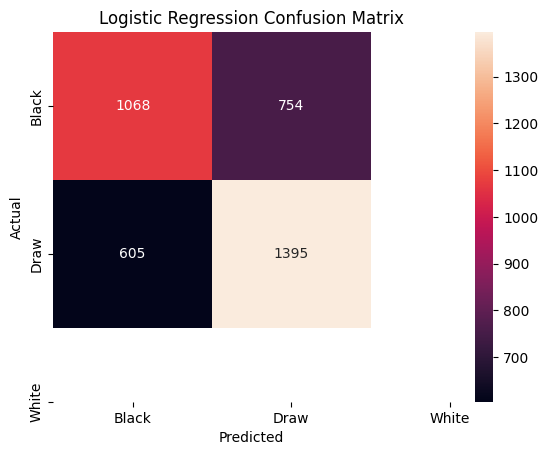

In [18]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000) # max_iter might be needed for convergence
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Black', 'Draw', 'White'], yticklabels=['Black', 'Draw', 'White'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


Random Forest Performance:
              precision    recall  f1-score   support

        -1.0       0.63      0.62      0.63      1822
         1.0       0.66      0.67      0.66      2000

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822



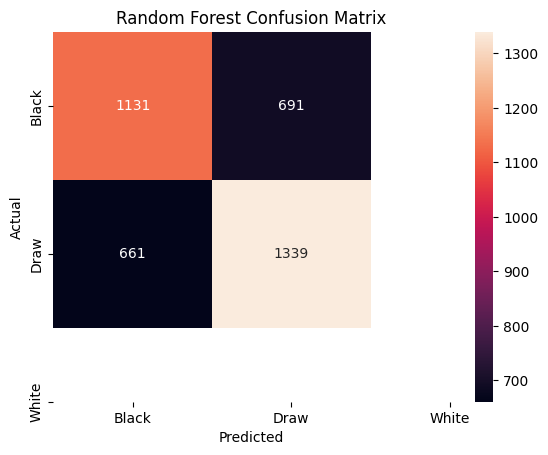

In [19]:
# Initialize and train the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=3, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Visualize the Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=['Black', 'Draw', 'White'], yticklabels=['Black', 'Draw', 'White'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()

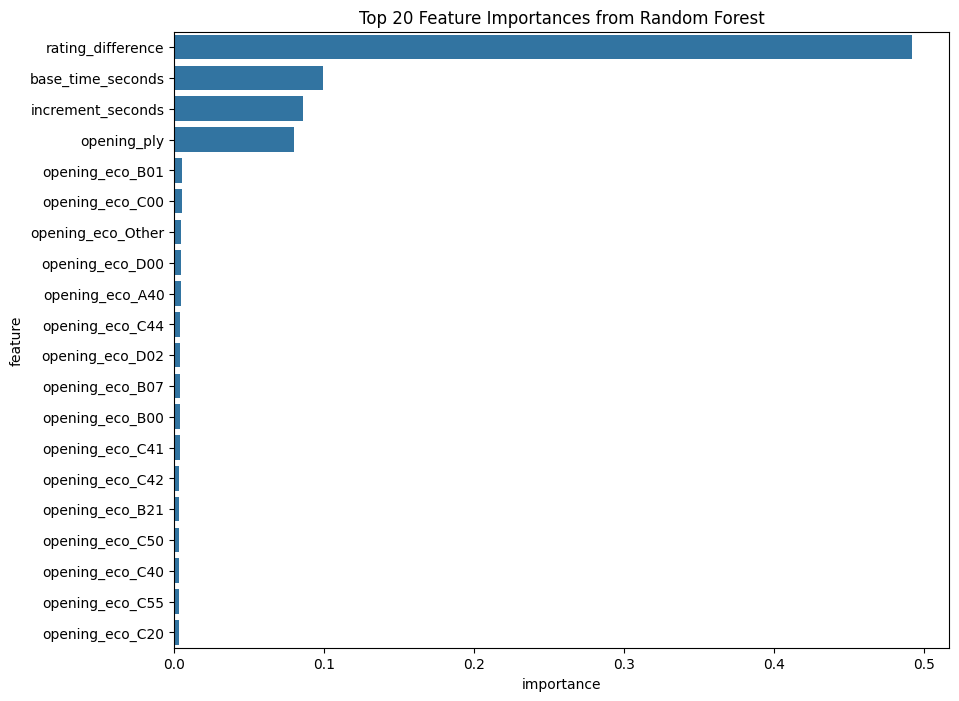

In [20]:
# Extract feature importances from the trained Random Forest model
importances = rf_clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance and plot the top 20 features
top_20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Define the SMOTE strategy
smote = SMOTE(random_state=42)

# Create a pipeline that first applies SMOTE and then trains the classifier
pipeline = Pipeline([('smote', smote), ('classifier', rf_model)])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_smote = pipeline.predict(X_test)

# Evaluate the SMOTE model
print("\nRandom Forest Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))


Random Forest Performance with SMOTE:
              precision    recall  f1-score   support

        -1.0       0.62      0.66      0.64      1822
         1.0       0.67      0.63      0.65      2000

    accuracy                           0.64      3822
   macro avg       0.64      0.64      0.64      3822
weighted avg       0.65      0.64      0.64      3822



In [22]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'] # Keep the balanced setting!
}

# Initialize the Grid Search
# Using n_jobs=-1 will use all your CPU cores to speed it up
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation
                           n_jobs=-1,
                           verbose=2,
                           scoring='f1_macro') # 'f1_macro' is a great metric for imbalanced classes

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("\nBest Parameters found by Grid Search:", grid_search.best_params_)
print("Best macro F1-score on validation set:", grid_search.best_score_)

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("\nFinal Tuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   1.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   1.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   1.1s
[CV] END cla

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline that first scales the data, then runs the classifier.
# We'll use your best Random Forest parameters from the Grid Search.
pipeline_final = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', 
                                         max_depth=None, 
                                         min_samples_leaf=2, 
                                         n_estimators=100,
                                         random_state=42, 
                                         n_jobs=-1))
])

# Train the final pipeline
pipeline_final.fit(X_train, y_train)

# Evaluate the final model
y_pred_final = pipeline_final.predict(X_test)

print("\nFinal Scaled & Tuned Random Forest Performance:")
print(classification_report(y_test, y_pred_final))


Final Scaled & Tuned Random Forest Performance:
              precision    recall  f1-score   support

        -1.0       0.63      0.64      0.63      1822
         1.0       0.67      0.66      0.66      2000

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822



In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Create a pipeline that first scales the data, then runs the XGBoost classifier.
# We include two common parameters to ensure smooth operation.
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Train the XGBoost model on your data
print("Training XGBoost model...")
pipeline_xgb.fit(X_train, y_train)

# Evaluate the XGBoost model
print("\nEvaluating XGBoost model...")
y_pred_xgb = pipeline_xgb.predict(X_test)

print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <98D50080-9632-3EA4-B874-146E55453763> /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
import lightgbm as lgb

# Initialize and train a LightGBM model
# It also supports class_weight='balanced'
lgbm = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

# We can put this in the same scaling pipeline
pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lgbm)
])

pipeline_lgbm.fit(X_train, y_train)

# Evaluate the LightGBM model
y_pred_lgbm = pipeline_lgbm.predict(X_test)

print("\nLightGBM Performance:")
print(classification_report(y_test, y_pred_lgbm))